In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.linalg as SLA

In [198]:
m_e = 9.11e-31 # kg
Z = 38
hbar = 1.05e-34 # (m^2)kg/s
q = 1.6e-19 # C
eps0 = 8.85e-12 # Farad/meter
au = 5.29e-11 # m
amu = 4.36e-18 # J, one Hartree
E_SrIonIon = 11.03019*1.6e-19 # Joules; From NIST paper below
wn_to_J = .0001239841930098*1.6e-19
c = 3e8

In [575]:
def E(I): ## electric field amplitude for a given intensity
    return np.sqrt((2/(c*eps0))*I)

In [577]:
# For now, back out the dipole matrix elements from the Gil,...,Pohl spin squeezing paper
# They quote a Rabi frqeuency of Rabi_To_Rydberg55/(2*pi) of 20 MHz for a beam waist of ~30 microns, and power ~.5W
P_pohl = .5 # watts
w_pohl = 30e-6 # meters
# the peak intensity of such a beam would be
I_pohl = P_pohl/(np.pi*(w_pohl**2)) # peak intensity

## Quoted Rabi frequency from clock state to n=55 rydberg S state:
f_rabi_ryd = 2*np.pi*20e6 ## 2*pi*Hz

# now back out dipole matrix element:
d_3p0_Ryd = (f_rabi_ryd*hbar)/E(I_pohl)

In [589]:
# as a check, calculate the decay rate into clock state that this would give, using transition wavelength of 316.5nm
omega = 2*np.pi*c/(316.5e-9)
A = 2*(omega**3)*(d_3p0_Ryd**2)/(3*eps0*(c**3)*(hbar*2*np.pi)) ## Einstein A coefficient
print('If 3p0 were the only decay channel, n=55 S state lifetime would be ' + str((1/A)*1e6) + ' microseconds')

If 3p0 were the only decay channel, n=55 S state lifetime would be 856.5051949540216 microseconds


In [593]:
# Now give function for Rabi frqeuency as function of intensity, using this dipole matrix element
def Omega(I):
    return d_3p0_Ryd*E(I)/hbar
print((Omega(I_pohl)/(2*np.pi))*1e-6)

20.0


At this point, need the C_6 van der Waals coefficient to get the interactions. There is a lovely paper that calculates (and nicely tabulates) these values for Alkaline-Earth Atoms:

https://iopscience.iop.org/article/10.1088/0953-4075/45/13/135004

See the supplementary info for their data

In [454]:
C6 = (-2.06e20)*amu # Joules

In [623]:
# V0 is the interaction strength, as a function of the detuning and intensity
def V0(I,Delta):
    return ((Omega(I)/(2*Delta))**3)*hbar*Omega(I)
# Rc is the blockade radius. It is also a function of the detuning \Delta
def Rc(Delta):
    return (np.abs(C6/(2*hbar*Delta))**(1/6.0))*au # converts from atomic units to SI

In [627]:
# Interaction strength between sites separated by a distance r
def V(r,I,Delta):
    return (V0(I,Delta)*(Rc(Delta))**6)/(r**6 + Rc(Del)**6)

In [656]:
Del = 20*Omega(I_pohl) # Detuning in Pohl paper is 20 tiems the rabi frequency (I think they forgot the twidle in def.)

# In Pohl paper, V0 is aabout 2 kHz for their parameters. Just check that functions above reproduce that
print("V_0/(hbar) = " + str((V0(I_pohl,Del)/hbar)*1e-3) + " kHz")
# The Pohl paper is a little unclear on units. Unlike iwth Rabi frequency, they do not specify dividing V0 by 2*pi
# I think their 2 kHz term has a factor of 2*pi in it, i.e. it is V0/(hbar)

V_0/(hbar) = 1.9634954084936205 kHz


Text(0.5,1,'Dressed Interaction Strength')

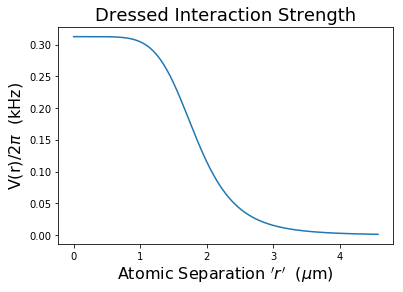

In [672]:
a = (813.5e-9)/2 # length scale, lattice constant in magic wavelength lattice
Del = 20*Omega(I_pohl)
x = np.linspace(0,Rc(Del)*2.5,1000)
plt.plot(x*1e6,1e-3*V(x,I_pohl,Del)/(2*np.pi*hbar))
plt.ylabel("V(r)/2$\pi$  (kHz)",fontsize=16)
plt.xlabel("Atomic Separation $'r'$  ($\mu$m)",fontsize=16)
plt.title("Dressed Interaction Strength",fontsize=18)

Now the interaction strengths as a function of Rabi frequency, atomic separation, etc. are mapped out. Next figure out a beam waist that achieves the stated goal of less than 10% variation in rabi frequency across the atom array

In [673]:
# Intensity as a function of beam parameters
def I(r,z,w0,P):
    I0 = P/(np.pi*(w0**2))
    zR = np.pi*(w0**2)/(317e-9)
    w = w0*np.sqrt(1 + (z/zR)**2)
    return I0*((w0/w)**2)*np.exp(-2*(r**2)/(w**2))

9.336087208862764 percent variation in Rabi frequency across array


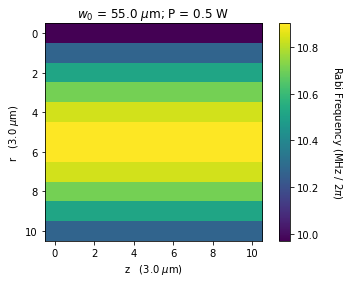

In [707]:
P = .5 # 1 W of power
w0 = 55e-6 # beam waist
I0 = P/(np.pi*(w0**2)) # peak intensity
N = 11 ## N by N array

spacing = (3e-6)
RabiMap = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        RabiMap[i,j] = Omega(I(i*spacing - (N*spacing/2),j*spacing - (N*spacing/2),w0,P))
        
fig, ax = plt.subplots()
pos = ax.imshow(RabiMap/(2*np.pi*1e6), interpolation='none')
cbar = fig.colorbar(pos, ax=ax)
plt.xlabel("z   (" + str(round(spacing/1e-6,3)) + " $\mu$m)")
plt.ylabel("r   (" + str(round(spacing/1e-6,3)) + " $\mu$m)")
plt.title("$w_0$ = " + str(round(w0/1e-6,4)) + " $\mu$m; P = " + str(P) + " W")
cbar.ax.set_ylabel("Rabi Frequency (MHz / $2\pi$)",labelpad=25, rotation=270)

print(str(((RabiMap.max() - RabiMap.min())/RabiMap.min())*100) + " percent variation in Rabi frequency across array")